<a href="https://colab.research.google.com/github/sgywhetstone/CholletDLWorkbooks/blob/master/CholletC4IMDBClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Improving on the C3 IMBD classification model by using dropout and weight regularization 

First we experiment with larger and smaller models to see the effects of over/underfitting. Finding the existing size to be a reasonable compromise, we test different versions of regularization and dropout rates, before training a final model using both. 

In [0]:
#Using the code from C3, prepare the dataset and generate the old model

import keras
import numpy as np
keras.__version__

#Set the number of words we keep from the reviews - e.g. if max_words = 10000, we keep only the top 10 000 most common words
max_words = 10000

from keras.datasets import imdb

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words= max_words)

# restore np.load for future normal usage
np.load = np_load_old

#Encode the reviews via one-hot encoding
def vectorize_sequences(sequences, dimension = max_words):  #One-hot function
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

#Vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

#Vectorize training and test labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


#Create a 10k sample validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [0]:
#Old Model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(max_words,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [0]:
#Smaller Model
small_model = models.Sequential()
small_model.add(layers.Dense(4, activation='relu', input_shape=(max_words,)))
small_model.add(layers.Dense(4, activation='relu'))
small_model.add(layers.Dense(1, activation='sigmoid'))

small_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [0]:
#Larger Model
large_model = models.Sequential()
large_model.add(layers.Dense(512, activation='relu', input_shape=(max_words,)))
large_model.add(layers.Dense(512, activation='relu'))
large_model.add(layers.Dense(1, activation='sigmoid'))

large_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [33]:
#Train models and collect validation data

model_hist = model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_val, y_val))

small_model_hist = small_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_val, y_val))

large_model_hist = large_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_val, y_val))

Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 199us/step - loss: 0.4519 - acc: 0.8185 - val_loss: 0.2812 - val_acc: 0.9106
Epoch 2/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.2525 - acc: 0.9109 - val_loss: 0.1951 - val_acc: 0.9368
Epoch 3/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.1975 - acc: 0.9287 - val_loss: 0.1514 - val_acc: 0.9536
Epoch 4/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.1656 - acc: 0.9418 - val_loss: 0.1276 - val_acc: 0.9618
Epoch 5/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.1471 - acc: 0.9466 - val_loss: 0.1106 - val_acc: 0.9672
Epoch 6/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.1278 - acc: 0.9557 - val_loss: 0.0974 - val_acc: 0.9720
Epoch 7/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.1146 - acc: 0.9597 - val_loss: 0.0865 - 

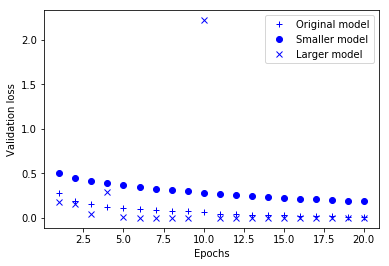

In [34]:
#Plotting validation loss for all 3 models

epochs = range(1, 21)
original_val_loss = model_hist.history['val_loss']
small_model_val_loss = small_model_hist.history['val_loss']
large_model_val_loss = large_model_hist.history['val_loss']

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, small_model_val_loss, 'bo', label='Smaller model')
# "bx" is for "blue x"
plt.plot(epochs, large_model_val_loss, 'bx', label='Larger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


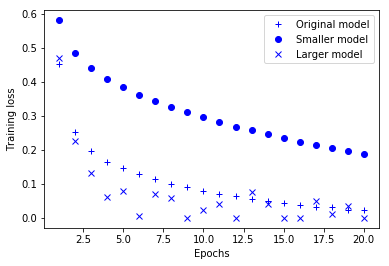

In [35]:
#Plotting training loss for all 3 models

epochs = range(1, 21)
original_train_loss = model_hist.history['loss']
small_model_train_loss = small_model_hist.history['loss']
large_model_train_loss = large_model_hist.history['loss']

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_train_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, small_model_train_loss, 'bo', label='Smaller model')
# "bx" is for "blue x"
plt.plot(epochs, large_model_train_loss, 'bx', label='Larger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

Now we use regularization to the model - see notes for a discussion of regularization and kernel methods. 

We compare validation losses from original model with regularized version using three different regularizers. 

In [36]:
#Creating model with L1 regularization
from keras import regularizers

l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

#Creating model with L2 regularization
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

#Creating model with L1/L2 regularization
from keras import regularizers

l1_l2_model = models.Sequential()
l1_l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation='relu', input_shape=(10000,)))
l1_l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation='relu'))
l1_l2_model.add(layers.Dense(1, activation='sigmoid'))

#Compile models
l1_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l1_model_hist = l1_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))

l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))

l1_l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l1_l2_model_hist = l1_l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))


Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 204us/step - loss: 0.9061 - acc: 0.7910 - val_loss: 0.6333 - val_acc: 0.8535
Epoch 2/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.5950 - acc: 0.8633 - val_loss: 0.5769 - val_acc: 0.8633
Epoch 3/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.5508 - acc: 0.8728 - val_loss: 0.5474 - val_acc: 0.8688
Epoch 4/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.5275 - acc: 0.8774 - val_loss: 0.5209 - val_acc: 0.8808
Epoch 5/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.5151 - acc: 0.8793 - val_loss: 0.4936 - val_acc: 0.8885
Epoch 6/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.5041 - acc: 0.8826 - val_loss: 0.5253 - val_acc: 0.8670
Epoch 7/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.4999 - acc: 0.8804 - val_loss: 0.5085 - 

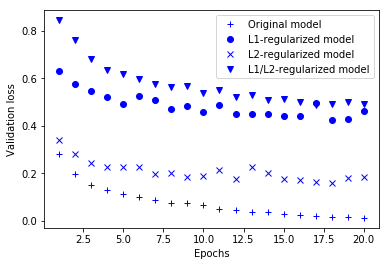

In [37]:
#Plot validation loss
l1_model_val_loss = l1_model_hist.history['val_loss']
l2_model_val_loss = l2_model_hist.history['val_loss']
l1_l2_model_val_loss = l1_l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l1_model_val_loss, 'bo', label='L1-regularized model')
plt.plot(epochs, l2_model_val_loss, 'bx', label='L2-regularized model')
plt.plot(epochs, l1_l2_model_val_loss, 'bv', label='L1/L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Now we experiment with dropout. We compare validation losses from different dropout rates. 

In [38]:
#Create three models with dropout rates of .2, .5, and .8

dpt2_model = models.Sequential()
dpt2_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt2_model.add(layers.Dropout(0.2))
dpt2_model.add(layers.Dense(16, activation='relu'))
dpt2_model.add(layers.Dropout(0.2))
dpt2_model.add(layers.Dense(1, activation='sigmoid'))

dpt2_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt2_model_hist = dpt2_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

dpt5_model = models.Sequential()
dpt5_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt5_model.add(layers.Dropout(0.5))
dpt5_model.add(layers.Dense(16, activation='relu'))
dpt5_model.add(layers.Dropout(0.5))
dpt5_model.add(layers.Dense(1, activation='sigmoid'))

dpt5_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt5_model_hist = dpt5_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

dpt8_model = models.Sequential()
dpt8_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt8_model.add(layers.Dropout(0.8))
dpt8_model.add(layers.Dense(16, activation='relu'))
dpt8_model.add(layers.Dropout(0.8))
dpt8_model.add(layers.Dense(1, activation='sigmoid'))

dpt8_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt8_model_hist = dpt8_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 202us/step - loss: 0.5104 - acc: 0.7743 - val_loss: 0.3521 - val_acc: 0.8791
Epoch 2/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.3253 - acc: 0.8820 - val_loss: 0.2291 - val_acc: 0.9236
Epoch 3/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.2466 - acc: 0.9115 - val_loss: 0.1693 - val_acc: 0.9463
Epoch 4/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.2024 - acc: 0.9312 - val_loss: 0.1449 - val_acc: 0.9517
Epoch 5/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.1691 - acc: 0.9426 - val_loss: 0.1112 - val_acc: 0.9648
Epoch 6/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.1429 - acc: 0.9510 - val_loss: 0.1095 - val_acc: 0.9645
Epoch 7/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.1235 - acc: 0.9587 - val_loss: 0.0789 - 

W0715 23:42:49.650010 140572917438336 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0715 23:42:49.685447 140572917438336 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 210us/step - loss: 0.6949 - acc: 0.5123 - val_loss: 0.6823 - val_acc: 0.7007
Epoch 2/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.6777 - acc: 0.5680 - val_loss: 0.6371 - val_acc: 0.7851
Epoch 3/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.6550 - acc: 0.6180 - val_loss: 0.5936 - val_acc: 0.8408
Epoch 4/20
25000/25000 [==============================] - 4s 145us/step - loss: 0.6306 - acc: 0.6518 - val_loss: 0.5421 - val_acc: 0.8599
Epoch 5/20
25000/25000 [==============================] - 4s 145us/step - loss: 0.6110 - acc: 0.6683 - val_loss: 0.5143 - val_acc: 0.8781
Epoch 6/20
25000/25000 [==============================] - 4s 145us/step - loss: 0.5934 - acc: 0.6803 - val_loss: 0.4857 - val_acc: 0.8838
Epoch 7/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.5823 - acc: 0.6933 - val_loss: 0.4614 - 

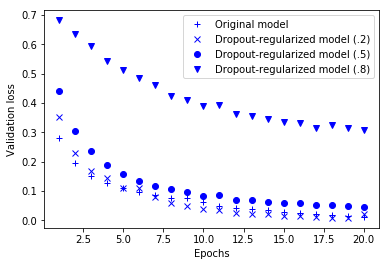

In [39]:
#Plot validation loss

dpt2_model_val_loss = dpt2_model_hist.history['val_loss']
dpt5_model_val_loss = dpt5_model_hist.history['val_loss']
dpt8_model_val_loss = dpt8_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt2_model_val_loss, 'bx', label='Dropout-regularized model (.2)')
plt.plot(epochs, dpt5_model_val_loss, 'bo', label='Dropout-regularized model (.5)')
plt.plot(epochs, dpt8_model_val_loss, 'bv', label='Dropout-regularized model (.8)')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Now we train a final version of the model (with both dropout and L2 regularization), validate to find optimal number of epochs, and test against the test data.

In [0]:
#Using .5 dropout rate and L2 regularization
final_model = models.Sequential()
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(max_words,)))
final_model.add(layers.Dropout(.5))
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
final_model.add(layers.Dropout(.5))
final_model.add(layers.Dense(1, activation='sigmoid'))

final_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [41]:
#Train model for 20 epochs
final_model_hist = final_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 6s 224us/step - loss: 0.6322 - acc: 0.6785 - val_loss: 0.4693 - val_acc: 0.8829
Epoch 2/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.4813 - acc: 0.8137 - val_loss: 0.3374 - val_acc: 0.9055
Epoch 3/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.3994 - acc: 0.8638 - val_loss: 0.2803 - val_acc: 0.9221
Epoch 4/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.3526 - acc: 0.8859 - val_loss: 0.2444 - val_acc: 0.9353
Epoch 5/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.3233 - acc: 0.9014 - val_loss: 0.2262 - val_acc: 0.9412
Epoch 6/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.3048 - acc: 0.9111 - val_loss: 0.2129 - val_acc: 0.9477
Epoch 7/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.2899 - acc: 0.9190 - val_loss: 0.2036 - 

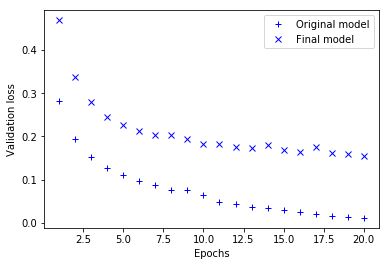

In [42]:
#Compare validation loss against original model
final_model_val_loss = final_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, final_model_val_loss, 'bx', label='Final model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [47]:
#Retrain final and original models to optimal number of epochs
model.fit(x_train, y_train, epochs=3, batch_size=512)
final_model.fit(x_train, y_train, epochs=3, batch_size=512)

Epoch 1/3
25000/25000 [==============================] - 3s 131us/step - loss: 0.0090 - acc: 0.9977
Epoch 2/3
25000/25000 [==============================] - 3s 119us/step - loss: 0.0064 - acc: 0.9981
Epoch 3/3
25000/25000 [==============================] - 3s 117us/step - loss: 0.0014 - acc: 1.0000
Epoch 1/3
25000/25000 [==============================] - 3s 120us/step - loss: 0.2243 - acc: 0.9414
Epoch 2/3
25000/25000 [==============================] - 3s 121us/step - loss: 0.2251 - acc: 0.9418
Epoch 3/3
25000/25000 [==============================] - 3s 118us/step - loss: 0.2272 - acc: 0.9412


In [48]:
#Compare test data
original_results = model.evaluate(x_test, y_test)
final_results = final_model.evaluate(x_test, y_test)

print("Original model:", original_results)
print("Final model:", final_results)

25000/25000 [==============================] - 2s 99us/step
Original model: [1.1759914930176736, 0.84204]
Final model: [0.47480856528282167, 0.8742]
